# Synthetic data generation - Frequency [Hz]

## Data fixing

For some reason, there are some errors with the obtained data. The *Demand* column has NaN values, thus I will be interpolating to fill these values

In [2]:
import pandas as pd
import numpy as np
from google.colab import drive

drive.mount('/content/drive')

path = '/content/drive/MyDrive/Deep Learning/Project 2/Spain/spain_energy_generation_merged.csv'
df = pd.read_csv(path)

# Interpolate the values
# By default, method='linear' is used, which fits your need to fill the gap smoothly.
df['Demand'] = df['Demand'].interpolate()

# Save the result back to a CSV
df.to_csv('/content/drive/MyDrive/Deep Learning/Project 2/Spain/spain_energy_generation_merged_with interpolation.csv', index=False)

Mounted at /content/drive


## Noise addition

The data we have has a density of 1 value per 10 minutes. We want to make it 1 value every 4 seconds. However, linear interpolation woudn't completely match the real world, which is why I'm adding slight randomness when interpolating this values.

In [3]:
# I used gemini for this part of the project
import pandas as pd
import numpy as np

# 1. Loading the CSV file
df = pd.read_csv('/content/drive/MyDrive/Deep Learning/Project 2/Spain/spain_energy_generation_merged_with interpolation.csv')

# 2. Converting datetime column and set as index
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

# 3. Create the new 4-second grid
# We generate a new index from the start to the end of your data with 4s freq
new_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='4S')

# Reindex the dataframe to this new grid (this introduces NaNs)
df_resampled = df.reindex(new_index)

# 4. Interpolation with specific Random Noise
# Loop through each numeric column to process them
numeric_cols = df_resampled.select_dtypes(include=[np.number]).columns

for col in numeric_cols:
    s = df_resampled[col]

    # Track which values are original so we don't add noise to them
    is_original = s.notna()

    # Calculate the "mean value of the two values interpolating between"
    # ffill gets the start of the gap, bfill gets the end of the gap
    gap_start = s.ffill()
    gap_end = s.bfill()
    gap_mean = (gap_start + gap_end) / 2.0

    # Calculate standard deviation (0.5% of the mean)
    sigma = 0.005 * gap_mean

    # Ensure sigma is non-negative for numpy.random.normal
    sigma = np.abs(sigma)

    # Perform standard linear interpolation
    s_interp = s.interpolate(method='linear')

    # Generate Gaussian noise for the entire column based on the local sigma
    # We use a loop or numpy vectorization. Since sigma varies, we pass it to normal()
    # Note: If sigma contains NaNs (edges), fill with 0 to avoid errors
    sigma = sigma.fillna(0)
    noise = np.random.normal(loc=0.0, scale=sigma, size=len(s))

    # Add noise ONLY to the interpolated values (where is_original is False)
    # We take the interpolated series and add noise selectively
    # ~is_original gives us the True/False mask for the new rows
    s_interp.loc[~is_original] += noise[~is_original]

    # Assign the result back to the dataframe
    df_resampled[col] = s_interp

# 5. Clean up and Save
# Reset index to make datetime a column again
df_resampled.reset_index(inplace=True)
df_resampled.rename(columns={'index': 'datetime'}, inplace=True)

# Save to new CSV
df_resampled.to_csv('/content/drive/MyDrive/Deep Learning/Project 2/Spain/spain_energy_generation_merged_with interpolation with noise.csv', index=False)

print("Processing complete. Saved to 'interpolated_with_noise.csv'.")
print(df_resampled.head())

/tmp/ipython-input-1193780287.py:15: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  new_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='4S')


Processing complete. Saved to 'interpolated_with_noise.csv'.
                   datetime  Total Generation   Solar PV  Solar Thermal  \
0 2023-03-03 23:00:00+00:00      27050.500000  16.000000     259.000000   
1 2023-03-03 23:00:04+00:00      27041.327274  15.876847     259.763965   
2 2023-03-03 23:00:08+00:00      27226.301989  15.925095     260.089304   
3 2023-03-03 23:00:12+00:00      27215.702401  15.844141     259.790057   
4 2023-03-03 23:00:16+00:00      27304.671154  15.911594     258.010691   

          Wind        Demand      Nuclear        Hydro        Coal  
0  6708.000000  27729.000000  6098.500000  5601.000000  945.000000  
1  6732.043464  27977.979658  6133.392455  5605.445802  941.354623  
2  6691.131517  27808.525714  6141.389416  5597.820727  942.512590  
3  6712.548870  27711.237627  6063.532868  5639.818317  948.153224  
4  6651.050640  27747.177955  6107.173559  5607.193575  944.239875  


## Calculating the frequency

Now that we have the generation data, we can canculate the frequency throug time solving differentiable equations. To simplify things, we are assignating  the same inertia constant (H) value to all the generators of the same power source. The values assigned are :



*   Solar PV: 0
*   Solar Thermal: 4s
*   Wind: 1.5s
*   Nuclear: 5s
*   Hydro: 3.5s
*   Coal: 5s
*   Rest: 2s

The initial frequency value chosen is 50Hz.

**Important note:** For some reason, the fundamental equation diverged to infinity, proving how highly unstable the results were.

$$2H\frac{df}{dt} = P_m - P_e$$

 So the following modifications are enforced:


1.   Scaling the demand so that it matches the generation:
$$\int^T (P_m-P_e)dt = 0$$
2.   Forcing the frequency to stay bounded between 49 and 51 Hz
3.   Addition of a damping factor, so the equation results in:
$$2H\frac{df}{dt} + D\cdotΔf = P_m - P_e$$

In [ ]:
import pandas as pd
import numpy as np

def calculate_grid_frequency_stable(file_path="/content/drive/MyDrive/Deep Learning/Project 2/Spain/spain_energy_generation_merged_with interpolation with noise.csv"):
    print(f"📂 Loading {file_path}...")
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print("❌ File not found.")
        return

    # Setup datetime index
    if 'datetime' in df.columns:
        df['datetime'] = pd.to_datetime(df['datetime'], utc=True)
        df.set_index('datetime', inplace=True)

    # 1. Scaling Generation to match Demand
    mean_gen = df["Total Generation"].mean()
    mean_demand = df["Demand"].mean()
    scaling_factor = mean_demand / mean_gen if mean_gen != 0 else 1.0
    print(f"⚖️  Scaling Generation by {scaling_factor:.6f} to match Demand mean...")

    known_sources = ["Total Generation", "Solar PV", "Solar Thermal", "Wind", "Nuclear", "Hydro", "Coal"]
    for col in known_sources:
        if col in df.columns:
            df[col] *= scaling_factor

    # 2. Constants
    f0 = 50.0
    dt_total = 4.0  # Original data interval in seconds
    sub_steps = 40  # Number of sub-steps
    dt_sub = dt_total / sub_steps # 0.1 seconds
    D = 1500.0 # Damping factor

    # Inertia Constants (H)
    H = {
        "Solar PV": 0,
        "Solar Thermal": 4,
        "Wind": 1.5,
        "Nuclear": 5,
        "Hydro": 3.5,
        "Coal": 5
    }
    H_rest = 2.0
    INERTIA_MULTIPLIER = 5.0

    # 3. Calculate Kinetic Energy (KE)
    specific_sources = ["Solar PV", "Solar Thermal", "Wind", "Nuclear", "Hydro", "Coal"]
    # Ensure columns exist
    for col in specific_sources:
        if col not in df.columns:
            df[col] = 0.0

    df["Sum_Known"] = df[specific_sources].sum(axis=1)
    df["Rest"] = df["Total Generation"] - df["Sum_Known"]

    weighted_sum = df["Rest"] * H_rest
    for source, h_val in H.items():
        weighted_sum += df[source] * h_val

    # Apply Multiplier and STRICT Lower Bound to prevent division by zero
    df["Kinetic_Energy"] = weighted_sum * INERTIA_MULTIPLIER
    df["Kinetic_Energy"] = df["Kinetic_Energy"].clip(lower=100.0)

    # 4. Simulation Loop with Sub-stepping
    df["Imbalance"] = df["Total Generation"] - df["Demand"]
    imbalance_arr = df["Imbalance"].values
    ke_arr = df["Kinetic_Energy"].values

    freq_values = []
    current_f = f0

    print(f"🧮 Calculating Frequency (Sub-stepping: {sub_steps} steps of {dt_sub}s)...")

    for i in range(len(df)):
        # Get static values for this 4s interval
        P_imbalance_static = imbalance_arr[i]
        KE_static = ke_arr[i]

        # Inner loop: Sub-step integration
        for _ in range(sub_steps):
            # Damping depends on current instantaneous frequency
            P_damping = D * (current_f - 50.0)

            # Net Accelerating Power
            P_acc = P_imbalance_static - P_damping

            # Swing Equation Update
            delta_f = (f0 * P_acc * dt_sub) / (2 * KE_static)
            current_f += delta_f

            # CLAMPING: Strictly enforce bounds to prevent numerical explosion
            current_f = max(49.0, min(51.0, current_f))

        # Store the final frequency at the end of the 4s interval
        freq_values.append(current_f)

    df["Frequency"] = freq_values

    # 5. Save
    output_filename = "/content/drive/MyDrive/Deep Learning/Project 2/Spain/spain_electrical_grid_frequency.csv"
    cols_to_save = ["Total Generation", "Demand", "Imbalance", "Kinetic_Energy", "Frequency"]
    df[cols_to_save].to_csv(output_filename)

    print(f"\n✅ Calculation Complete.")
    print(f"📊 Initial Frequency: {freq_values[0]:.4f} Hz")
    print(f"📊 Min Frequency:     {min(freq_values):.4f} Hz")
    print(f"📊 Max Frequency:     {max(freq_values):.4f} Hz")
    print(f"📊 Final Frequency:   {freq_values[-1]:.4f} Hz")
    print(f"💾 Saved results to: {output_filename}")

if __name__ == "__main__":
    calculate_grid_frequency_stable()

The following code creates a plot that helps us visualize the frequency over time

Full Dataset Statistics:
count    2.116785e+07
mean     4.994966e+01
std      3.074515e-01
min      4.900000e+01
25%      4.976290e+01
50%      4.993980e+01
75%      5.012377e+01
max      5.100000e+01
Name: Frequency, dtype: float64


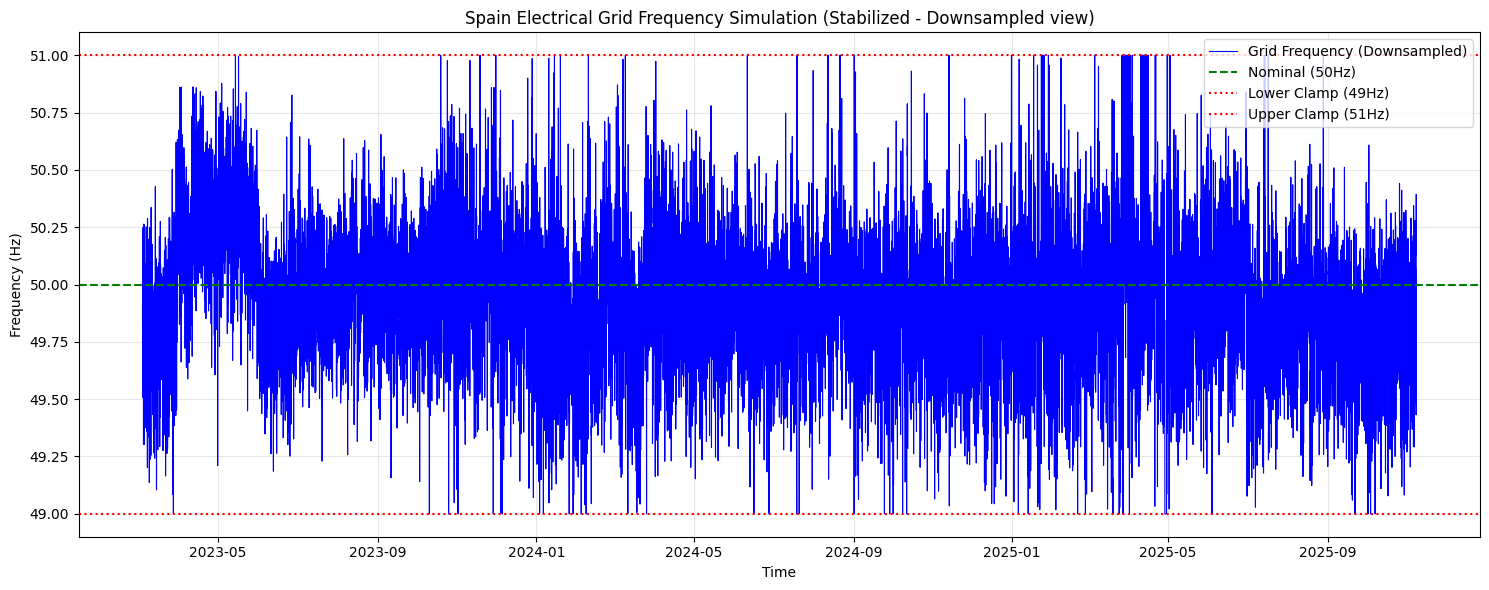

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load the calculated frequency data
file_path = "/content/drive/MyDrive/Deep Learning/Project 2/Spain/spain_electrical_grid_frequency.csv"
try:
    df_freq = pd.read_csv(file_path)
    if 'datetime' in df_freq.columns:
        df_freq['datetime'] = pd.to_datetime(df_freq['datetime'])
        df_freq.set_index('datetime', inplace=True)

    # 2. Display statistics on the full dataset
    print("Full Dataset Statistics:")
    print(df_freq['Frequency'].describe())

    # 3. Plot Frequency (Downsampled for performance)
    # There are ~21 million rows. Plotting every 1000th point reduces it to ~21k points, which is manageable.
    df_plot = df_freq.iloc[::1000]

    plt.figure(figsize=(15, 6))
    plt.plot(df_plot.index, df_plot['Frequency'], label='Grid Frequency (Downsampled)', color='blue', linewidth=0.8)
    plt.axhline(y=50.0, color='green', linestyle='--', label='Nominal (50Hz)')
    plt.axhline(y=49.0, color='red', linestyle=':', label='Lower Clamp (49Hz)')
    plt.axhline(y=51.0, color='red', linestyle=':', label='Upper Clamp (51Hz)')

    plt.title('Spain Electrical Grid Frequency Simulation (Stabilized - Downsampled view)')
    plt.xlabel('Time')
    plt.ylabel('Frequency (Hz)')
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print(f"❌ File not found: {file_path}")